# Image classification from scratch

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.

We use the `ImageFolder` utility to generate the datasets, and
we use Torchvision transforms module for image standardization and data augmentation.

In [4]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [6]:
import requests
from zipfile import ZipFile

# Define the URL and the filename
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
filename = "kagglecatsanddogs_5340.zip"

# Download the dataset
if not os.path.exists(filename):
    print("Downloading dataset...")
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)
    print("Download complete!")

# Extract the dataset
if not os.path.exists("PetImages"):
    print("Extracting dataset...")
    with ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall()
    print("Extraction complete!")

# Verify the contents
print("Contents of the current directory:")
print(os.listdir())
print("\nContents of the PetImages directory:")
print(os.listdir("PetImages"))

Download complete!
Extracting dataset...
Extraction complete!
Contents of the current directory:
['kagglecatsanddogs_5340.zip', 'PetImages', 'Image_classification_from_scratch_with_Pytorch.ipynb', 'readme[1].txt', 'CDLA-Permissive-2.0.pdf']

Contents of the PetImages directory:
['Cat', 'Dog']


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
subfolder contains image files for each category.

### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [4]:
num_skipped = 0

# Loop through the "Cat" and "Dog" folders
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            # Open the file in binary mode and check if it contains "JFIF" in the header
            with open(fpath, "rb") as fobj:
                is_jfif = b"JFIF" in fobj.read(10)
        except Exception as e:
            # If the file can't be read, treat it as corrupted
            is_jfif = False

        if not is_jfif:
            num_skipped += 1
            # Delete the corrupted image
            try:
                os.remove(fpath)
            except Exception as e:
                print(f"Error deleting file {fpath}: {e}")

print(f"Deleted {num_skipped} images.")

Deleted 1804 images.


## Generate a `Dataset`

In [5]:
from torch.utils.data import random_split

# Parameters
image_size = (180, 180)
batch_size = 128
validation_split = 0.2
seed = 1337

# Define transformations for preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# Load the dataset from the directory
dataset = datasets.ImageFolder("PetImages", transform=transform)

# Calculate the sizes for train and validation sets
dataset_size = len(dataset)
val_size = int(dataset_size * validation_split)
train_size = dataset_size - val_size

# Set the random seed and split the dataset
torch.manual_seed(seed)
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Check the sizes of the datasets
print(f"Training set size: {len(train_ds)}")
print(f"Validation set size: {len(val_ds)}")

Training set size: 18559
Validation set size: 4639


## Visualize the data

Here are the first 9 images in the training dataset.

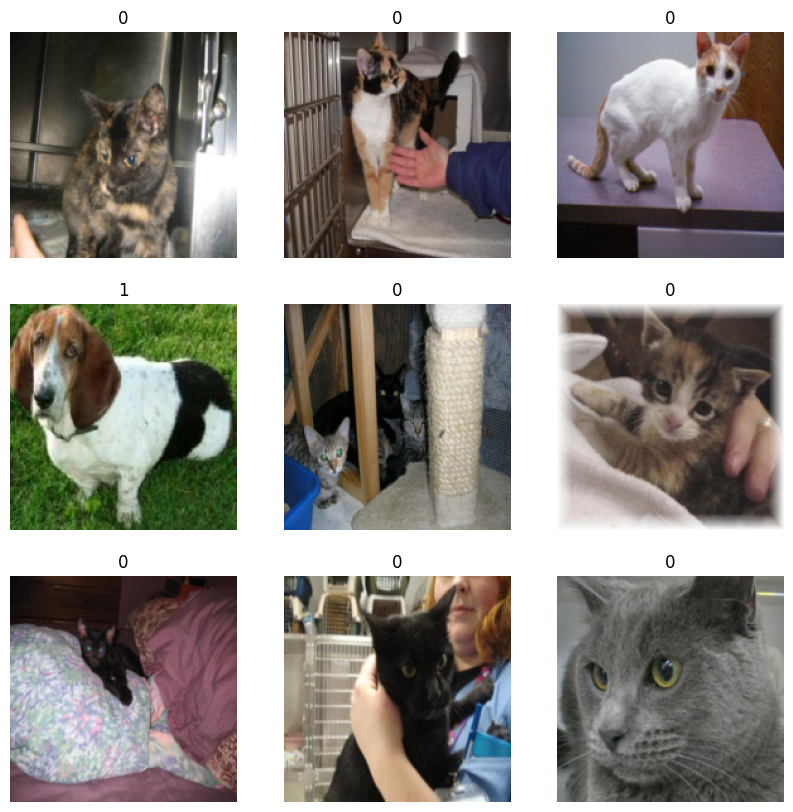

In [6]:
# Get the first batch of images and labels from the DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())  # Convert from CxHxW to HxWxC
    plt.title(int(labels[i]))
    plt.axis("off")
plt.show()

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [7]:
# Define data augmentation transformations
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flipping
    transforms.RandomRotation(10),          # Random rotation up to 10 degrees
])

# Example of applying augmentation to a batch of images
def augment_images(images):
    augmented_images = torch.stack([data_augmentation(image) for image in images])
    return augmented_images

Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first few images in the dataset:

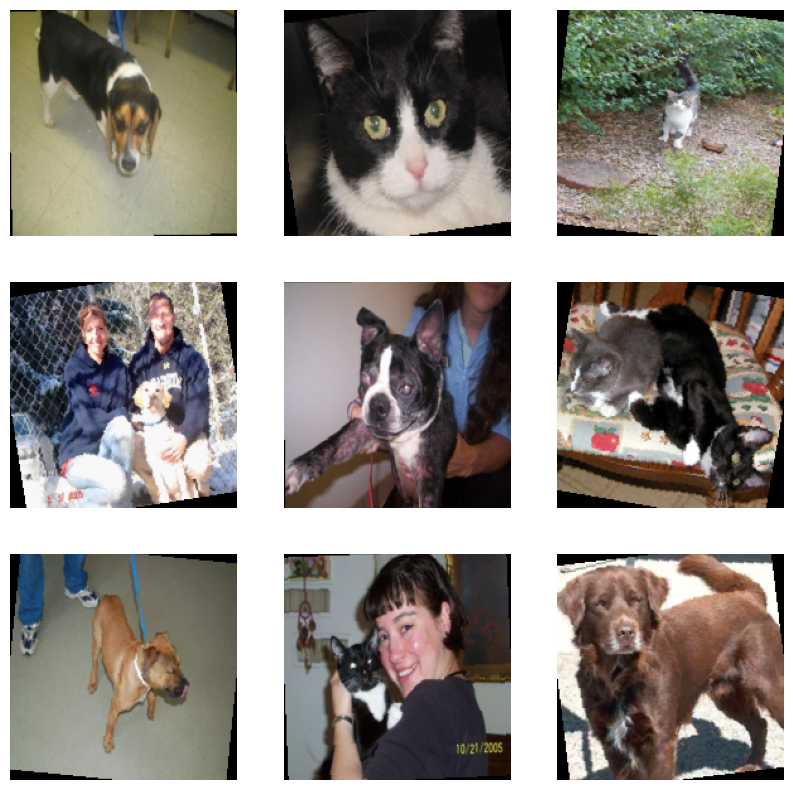

In [8]:
# Visualize augmented images
plt.figure(figsize=(10, 10))

# Get the first batch of images
data_iter = iter(train_loader)
images, _ = next(data_iter)

# Display augmented images
for i in range(9):
    augmented_image = data_augmentation(images[i])  # Apply augmentation
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.permute(1, 2, 0).numpy())  # Convert CxHxW to HxWxC
    plt.axis("off")

plt.show()

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Resize` function.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset:

In [9]:
# Transformation pipeline: Includes resizing, data augmentation (only for train), and normalization
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    data_augmentation,
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder("PetImages")
dataset_size = len(dataset)
val_size = int(dataset_size * validation_split)
train_size = dataset_size - val_size

# Split into training and validation datasets
torch.manual_seed(seed)
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Wrap the datasets with transformations
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset)

train_ds = TransformedDataset(train_ds, train_transform)
val_ds = TransformedDataset(val_ds, val_transform)

# DataLoaders with prefetching
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture.

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Resize` function.
- We include a `Dropout` function before the final classification layer.

In [11]:
import torch.nn.functional as F
from torchsummary import summary

class XceptionLikeModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(XceptionLikeModel, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Entry block
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(128)

        # Middle blocks
        self.blocks = nn.ModuleList()
        previous_size = 128
        for size in [256, 512, 728]:
            self.blocks.append(nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(previous_size, size, kernel_size=3, padding=1),
                nn.BatchNorm2d(size),
                nn.ReLU(),
                nn.Conv2d(size, size, kernel_size=3, padding=1),
                nn.BatchNorm2d(size),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            ))
            self.blocks.append(nn.Conv2d(previous_size, size, kernel_size=1, stride=2, padding=0))
            previous_size = size

        # Exit block
        self.conv_exit = nn.Conv2d(728, 1024, kernel_size=3, padding=1)
        self.bn_exit = nn.BatchNorm2d(1024)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(1024, 1 if num_classes == 2 else num_classes)

    def forward(self, x):
        # Entry block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        # Residual connections in the middle blocks
        for i in range(0, len(self.blocks), 2):
            residual = self.blocks[i + 1](x)
            x = self.blocks[i](x)
            x += residual

        # Exit block
        x = self.conv_exit(x)
        x = self.bn_exit(x)
        x = F.relu(x)

        # Global average pooling, dropout, and final dense layer
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = (3, 180, 180)
num_classes = 2
model = XceptionLikeModel(input_shape, num_classes).to(device)

# Test the model on a dummy input
dummy_input = torch.randn(1, *input_shape).to(device)  # Move input to GPU
output = model(dummy_input)
print(f"Output shape: {output.shape}")

# Display the model summary
summary(model, input_size=input_shape)

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 90, 90]           3,584
       BatchNorm2d-2          [-1, 128, 90, 90]             256
            Conv2d-3          [-1, 256, 45, 45]          33,024
              ReLU-4          [-1, 128, 90, 90]               0
            Conv2d-5          [-1, 256, 90, 90]         295,168
       BatchNorm2d-6          [-1, 256, 90, 90]             512
              ReLU-7          [-1, 256, 90, 90]               0
            Conv2d-8          [-1, 256, 90, 90]         590,080
       BatchNorm2d-9          [-1, 256, 90, 90]             512
        MaxPool2d-10          [-1, 256, 45, 45]               0
           Conv2d-11          [-1, 512, 23, 23]         131,584
             ReLU-12          [-1, 256, 45, 45]               0
           Conv2d-13          [-1, 512, 45, 45]       1,180,160
      

## Train the model

In [12]:
from torch.optim import Adam
from tqdm import tqdm  # For progress bar

# Parameters
epochs = 25
learning_rate = 3e-4

# Define optimizer, loss, and metrics
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    train_loss = 0
    train_correct = 0

    # Training step
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Move to GPU
        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Get predictions
        train_correct += (preds == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)

    # Validation step
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Save model checkpoint
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")

Epoch 1/25


100%|██████████| 145/145 [03:31<00:00,  1.46s/it]


Train Loss: 0.6303, Train Accuracy: 0.6504
Val Loss: 0.7914, Val Accuracy: 0.5609
Epoch 2/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.5189, Train Accuracy: 0.7454
Val Loss: 0.4718, Val Accuracy: 0.7836
Epoch 3/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.4102, Train Accuracy: 0.8211
Val Loss: 0.5652, Val Accuracy: 0.7275
Epoch 4/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.3238, Train Accuracy: 0.8609
Val Loss: 0.2961, Val Accuracy: 0.8754
Epoch 5/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.2613, Train Accuracy: 0.8877
Val Loss: 0.3907, Val Accuracy: 0.8431
Epoch 6/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.2116, Train Accuracy: 0.9161
Val Loss: 0.2774, Val Accuracy: 0.8937
Epoch 7/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.1841, Train Accuracy: 0.9265
Val Loss: 0.5310, Val Accuracy: 0.8049
Epoch 8/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.1596, Train Accuracy: 0.9344
Val Loss: 0.1527, Val Accuracy: 0.9399
Epoch 9/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.1437, Train Accuracy: 0.9440
Val Loss: 0.1288, Val Accuracy: 0.9504
Epoch 10/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.1306, Train Accuracy: 0.9471
Val Loss: 0.1692, Val Accuracy: 0.9340
Epoch 11/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.1147, Train Accuracy: 0.9551
Val Loss: 0.1348, Val Accuracy: 0.9502
Epoch 12/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.1070, Train Accuracy: 0.9574
Val Loss: 0.1279, Val Accuracy: 0.9526
Epoch 13/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0968, Train Accuracy: 0.9625
Val Loss: 0.1291, Val Accuracy: 0.9500
Epoch 14/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0869, Train Accuracy: 0.9652
Val Loss: 0.1171, Val Accuracy: 0.9545
Epoch 15/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0836, Train Accuracy: 0.9685
Val Loss: 0.1026, Val Accuracy: 0.9595
Epoch 16/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0801, Train Accuracy: 0.9681
Val Loss: 0.1055, Val Accuracy: 0.9586
Epoch 17/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0719, Train Accuracy: 0.9717
Val Loss: 0.1723, Val Accuracy: 0.9455
Epoch 18/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0655, Train Accuracy: 0.9741
Val Loss: 0.0982, Val Accuracy: 0.9655
Epoch 19/25


100%|██████████| 145/145 [03:30<00:00,  1.46s/it]


Train Loss: 0.0584, Train Accuracy: 0.9784
Val Loss: 0.1117, Val Accuracy: 0.9608
Epoch 20/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0626, Train Accuracy: 0.9755
Val Loss: 0.3189, Val Accuracy: 0.8866
Epoch 21/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0576, Train Accuracy: 0.9774
Val Loss: 0.1011, Val Accuracy: 0.9621
Epoch 22/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0532, Train Accuracy: 0.9797
Val Loss: 0.1303, Val Accuracy: 0.9575
Epoch 23/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0464, Train Accuracy: 0.9819
Val Loss: 0.1215, Val Accuracy: 0.9595
Epoch 24/25


100%|██████████| 145/145 [03:30<00:00,  1.45s/it]


Train Loss: 0.0425, Train Accuracy: 0.9839
Val Loss: 0.0961, Val Accuracy: 0.9651
Epoch 25/25


100%|██████████| 145/145 [03:30<00:00,  1.46s/it]


Train Loss: 0.0397, Train Accuracy: 0.9856
Val Loss: 0.1972, Val Accuracy: 0.9437


We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

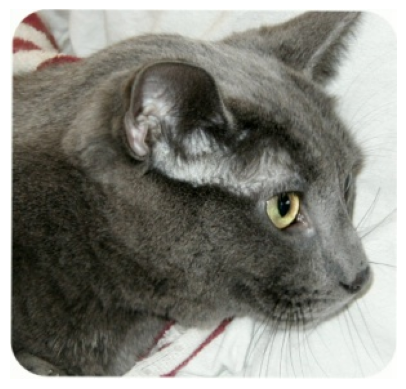

This image is 100.00% cat and 0.00% dog.


In [13]:
from PIL import Image

# Define the same image size as during training
image_size = (180, 180)

# Load and preprocess the image
image_path = "PetImages/Cat/6779.jpg"
img = Image.open(image_path).convert("RGB")  # Ensure it's in RGB format
plt.imshow(img)
plt.axis("off")
plt.show()

# Define preprocessing transformations (match training preprocessing)
preprocess = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Apply preprocessing
img_tensor = preprocess(img).unsqueeze(0).to(device)  # Add batch dimension and move to GPU/CPU

# Ensure the model is in evaluation mode
model.eval()

# Run inference
with torch.no_grad():
    predictions = model(img_tensor)
    score = torch.sigmoid(predictions[0]).item()  # Get the score

# Display result
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
